C:\Users\szhang\AppData\Local\Temp\ipykernel_34172\263612056.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  employee_counts = data.groupby(['Week Day', 'Time']).size().reset_index(name='Employee Count')


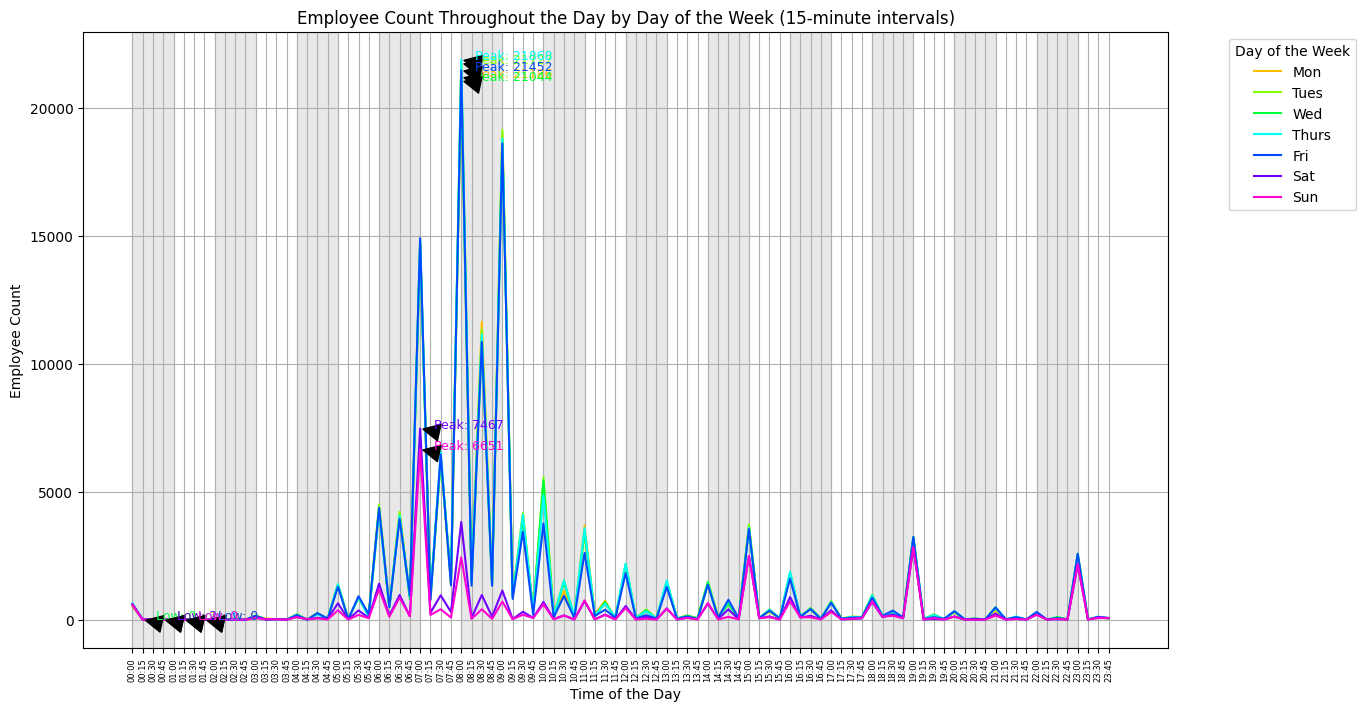

                  Peak  Low
Day of the Week            
Mon              21186    0
Tues             21727    1
Wed              21044    0
Thurs            21868    1
Fri              21452    0
Sat               7467    2
Sun               6651    0

Summary of Invalid Data:
Number of rows with invalid time values: 1

Sample of invalid data:
       Week Ending Week Day Sched Start Time Depart. Code Shift Period  \
714100         NaN      NaN              NaN          NaN          NaN   

        Shift Count  Time  
714100         6813   NaN  


In [5]:
# Required installations
!pip install pandas matplotlib seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the file
file_path = r'C:\\Users\\szhang\\Downloads\\test NYU.txt'
file_path = r"C:\\Users\\szhang\\Downloads\\00001_12876_Dept-Shift-Counts_v1.0_11-13-2019 1_rs.txt"
data = pd.read_csv(file_path, delimiter=',', skipinitialspace=True)

# Drop unnecessary columns
data = data.drop(columns=['Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'LINE'])

# Function to extract hour and minute safely
def extract_time(s):
    try:
        time_str = str(s).split()[-1]
        hour, minute = map(int, time_str.split(':'))
        return hour * 60 + minute
    except ValueError:
        return None

# Extract the time in minutes from 'Sched Start Time'
data['Time'] = data['Sched Start Time'].apply(extract_time)

# Identify rows with invalid time values
invalid_data = data[data['Time'].isna()]

# Drop rows with invalid time values
data = data.dropna(subset=['Time'])

# Convert time to 15-minute intervals and ensure it's numeric
data['Time'] = (data['Time'] // 15) * 15
data['Time'] = data['Time'].astype(int)

# Define a custom sorting order for weekdays
weekday_order = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
data['Week Day'] = pd.Categorical(data['Week Day'], categories=weekday_order, ordered=True)

# Group by 'Week Day' and 'Time' to count the number of employees
employee_counts = data.groupby(['Week Day', 'Time']).size().reset_index(name='Employee Count')
employee_counts['Employee Count'] = employee_counts['Employee Count'].astype(int)

# Initialize peak and low value storage
peak_values = []
low_values = []

# Plot settings
plt.figure(figsize=(14, 8))
colors = sns.color_palette("hsv", len(weekday_order))

# Alternate background color for every whole hour
for hour in range(0, 24):
    plt.axvspan(hour * 60, (hour + 1) * 60, color='lightgrey' if hour % 2 == 0 else 'white', alpha=0.5)

# Plot each day with a unique color and annotate peak and low points
for i, day in enumerate(weekday_order):
    day_data = employee_counts[employee_counts['Week Day'] == day]
    if not day_data.empty:
        plt.plot(day_data['Time'], day_data['Employee Count'], label=day, color=colors[i])
        
        # Annotate peak point
        peak_idx = day_data['Employee Count'].idxmax()
        peak = day_data.loc[peak_idx]
        peak_values.append(peak['Employee Count'])
        plt.annotate(f'Peak: {peak["Employee Count"]}', 
                     xy=(peak['Time'], peak['Employee Count']), 
                     xytext=(peak['Time'] + 20, peak['Employee Count'] + 1),
                     arrowprops=dict(facecolor='black', shrink=0.2),  # Reduce arrow head size
                     fontsize=9,
                     color=colors[i])
        
        # Annotate low point
        low_idx = day_data['Employee Count'].idxmin()
        low = day_data.loc[low_idx]
        low_values.append(low['Employee Count'])
        plt.annotate(f'Low: {low["Employee Count"]}', 
                     xy=(low['Time'], low['Employee Count']), 
                     xytext=(low['Time'] + 20, low['Employee Count'] - 1),
                     arrowprops=dict(facecolor='black', shrink=0.2),  # Reduce arrow head size
                     fontsize=9,
                     color=colors[i])

# Convert time in minutes back to HH:MM format for x-axis labels
time_labels = [f'{int(t//60):02d}:{int(t%60):02d}' for t in employee_counts['Time'].unique()]
plt.xticks(employee_counts['Time'].unique(), time_labels, rotation=90, fontsize=6)  # Reduce font size to 50%

# Add titles and labels
plt.title('Employee Count Throughout the Day by Day of the Week (15-minute intervals)')
plt.xlabel('Time of the Day')
plt.ylabel('Employee Count')
plt.legend(title='Day of the Week', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Show plot
plt.show()

# Create a table with peak and low values
summary_table = pd.DataFrame({
    'Day of the Week': weekday_order,
    'Peak': peak_values,
    'Low': low_values
}).set_index('Day of the Week')

print(summary_table)

# Summary of invalid data
print(f"\nSummary of Invalid Data:")
print(f"Number of rows with invalid time values: {len(invalid_data)}")
print("\nSample of invalid data:")
print(invalid_data.head())
